In [146]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import os
import time
import datetime as dt 
from pandas_datareader import data as web
import yfinance as yf
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from functions.datareader import pull_stock_data

<h1 style="color:orange">Load data using YFinance and save to local</h1>

In [101]:
# source for yfinance: https://pypi.org/project/yfinance/

In [102]:
start = dt.date(2015, 1, 1)
end = dt.date(2022, 2, 1)

# meta = yf.Tickers(['BBL.BK', 'KBANK.BK'])

In [103]:
# price_df = meta.history(period = 'MAX').sort_index()

In [104]:
# price_df[[c for c in price_df.columns if c[1] == 'BBL.BK']].tail(20)

In [105]:
sectors = {
    'banking': ['BBL', 'KBANK', 'SCB', 'BAY', 'TISCO', 'KTB', 'KKP', 'TTB'],
    'hospital': ['BDMS', 'BCH', 'BH', 'THG', 'PR9', 'EKH', 'IMH'],
    'infrastructure': ['AOT', 'BAFS', 'BTS', 'BEM', 'DMT'],
    'consumer_staple': ['BJC', 'OR', 'CPALL', 'CRC', 'MAJOR', 'GFPT', 'CPF', 'MAKRO', 'M'],
    'consumer_discretionary': ['COM7', 'CPW', 'SYNEX'],
    'technology': ['BBIK', 'IIG', 'BE8'],
    'industrial': ['WHA', 'AMATA'],
    'material': ['SCGP', 'HMPRO', 'GLOBAL', 'DOHOME', 'TPIPL', 'STGT', 'THMUI'],
    'utilities': ['RATCH', 'BGRIM', 'GULF', 'TPIPP', 'EGCO', 'EA', 'BANPU', 'ACE'],
    'petrochemistry': ['PTTGC', 'BCP', 'IRPC', 'IVL'],
    'real_estate': ['SIRI', 'QH', 'AP', 'SPALI', 'ORI', 'LALIN'],
    'hotel': ['MINT', 'CENTEL', 'ERW', 'AWC', 'SPA'],
    'consumer_finance': ['SAWAD', 'KTC', 'AEONTS', 'TIDLOR', 'MTC'],
    'insurance': ['BLA']
}

all_tickers = sectors.values()
all_tickers = [v + '.BK' for s in all_tickers for v in s]

In [106]:
# all_meta = yf.Tickers(all_tickers)

In [107]:
# all_price_df = all_meta.history(period = 'max')

In [108]:
# all_price_df.tail(1)

In [109]:
# # Price
# parent_dir = './data/set'
# for t in all_tickers:
#     t_trim = t.replace('.BK', '')
#     ticker_dir = f'{parent_dir}/{t_trim}'
#     if not os.path.exists(ticker_dir):
#         os.mkdir(ticker_dir)
    
#     ticker_cols = [c for c in all_price_df.columns if c[1] == t]
#     ticker_df = all_price_df[ticker_cols].dropna(axis = 0)
#     ticker_df.columns = [c[0].lower() for c in ticker_df.columns]
#     ticker_df.insert(0, 'ticker', t_trim)
#     ticker_df.index.name = 'date'

#     price_dir = f'{ticker_dir}/price'
#     if not os.path.exists(price_dir):
#         os.mkdir(price_dir)
#     years = sorted(list(set(ticker_df.index.year)))
#     for y in years:
#         year_df = ticker_df[ticker_df.index.year == y]
#         year_df.to_parquet(f'{price_dir}/{str(y)}.parquet')

In [110]:
# # to plot
# year_start = 2016
# # tickers = {'BBL': 'blue', 'KBANK': 'green', 'KKP': 'purple'}
# tickers = {'BGRIM': 'green', 'GULF': 'red'}
# plt.figure(figsize = (10, 3))
# for t in tickers:
#     ticker_df = all_df[all_df['ticker'] == t]['Close']

#     # ? filter year
#     ticker_df = ticker_df[ticker_df.index.year >= year_start]

#     first_value = ticker_df.iloc[0]
#     # ? normalize prices
#     ticker_df = ticker_df.div(first_value)
#     ticker_df.plot(color = tickers[t], label = t)
# plt.legend(loc = 'upper right')

<h1 style="color:salmon">Load data from local and use only close price</h1>

In [111]:
raw_df = pd.read_parquet('./data/set')

# convert index from datetime to date
raw_df.index = raw_df.index.date
raw_df.index.name = 'date'

raw_df.tail()

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-02-22,WHA,3.94,0.0,4.00,3.92,3.96,0.0,136125400.0
2023-02-23,WHA,3.94,0.0,3.96,3.90,3.94,0.0,52493400.0
2023-02-24,WHA,3.98,0.0,4.02,3.94,4.00,0.0,181460000.0
2023-02-27,WHA,4.06,0.0,4.08,3.94,4.00,0.0,145975100.0
2023-02-28,WHA,4.04,0.0,4.06,4.02,4.06,0.0,28374603.0


In [112]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
vk[0]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
# sector_mapper

raw_df['sector'] = raw_df['ticker'].map(sector_mapper)


<p>We'll define a starting period of our analysis. Therefore we'll need to know whether there are stocks of which the daily price data doesn't exist yet in that period.</p>

In [113]:
start_date = dt.date(2015, 1, 1)

first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= start_date else False)
# first_date_df.head()

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

In [114]:
# filter only selected stocks
df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')
df.head()

,ticker,close,dividends,high,low,open,stock splits,volume,sector
date,,,,,,,,,
2001-12-11,AEONTS,4.823158,0.0,5.126979,4.405405,4.481360,0.0,78469000.0,consumer_finance
2001-12-12,AEONTS,4.709226,0.0,5.013047,4.709226,4.937092,0.0,31076500.0,consumer_finance
2001-12-13,AEONTS,4.557314,0.0,4.785180,4.557314,4.747202,0.0,11258000.0,consumer_finance
2001-12-14,AEONTS,4.823158,0.0,4.899113,4.443382,4.557315,0.0,19788500.0,consumer_finance
2001-12-17,AEONTS,4.823158,0.0,4.899113,4.823158,4.899113,0.0,3423000.0,consumer_finance


In [115]:
close_df = df[['ticker', 'sector', 'close']]
close_df.head()

sector       banking                                                    \
ticker           BAY       BBL     KBANK       KKP       KTB     TISCO   
date                                                                     
2015-12-09 -1.484924 -0.919239 -1.555635 -0.353553 -1.272792  0.070711   
2015-12-11 -1.414214 -1.060660 -1.626346 -0.141421 -1.272792  0.212132   
2015-12-14 -1.414214 -1.131371 -1.484924 -0.424264 -1.272792 -0.070711   

sector                hospital                      ... real_estate     hotel  \
ticker           TTB       BCH      BDMS        BH  ...       SPALI    CENTEL   
date                                                ...                         
2015-12-09 -1.131371 -0.070711  0.919239  1.343503  ...   -1.202082  1.272792   
2015-12-11 -1.131371  0.070711  0.848528  1.414214  ...   -1.202082  1.343503   
2015-12-14 -1.060660  0.141421  0.989949  1.414214  ...   -1.202082  1.343503   

sector                                   consumer_finance                      \
ticker           ERW      MINT       SPA           AEONTS       KTC       MTC   
date                                                                            
2015-12-09 -0.636396  0.989949  1.626346        -0.424264  1.414214  1.555635   
2015-12-11 -0.424264  0.777817  1.626346        -0.070711  1.272792  1.555635   
2015-12-14 -0.707107  0.777817  1.626346         0.000000  1.272792  1.555635   

sector               insurance  
ticker         SAWAD       BLA  
date                            
2015-12-09  1.697056  0.494975  
2015-12-11  1.697056  0.141421  
2015-12-14  1.697056  0.070711  

[3 rows x 49 columns]

In [116]:
# calculate daily return 
daily_return_df = close_df.reset_index().pivot(index = 'date', columns = 'ticker', values = 'close')
daily_return_df = daily_return_df.pct_change()
daily_return_df = daily_return_df[daily_return_df.index >= start_date]
daily_return_df.head(2)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,RATCH,SAWAD,SIRI,SPA,SPALI,SYNEX,TISCO,TPIPL,TTB,WHA
date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.004608,0.025478,-0.031915,0.000000,-0.024000,-0.012048,-0.050279,-0.020619,0.018987,-0.015748,...,0.012766,-0.012048,-0.029412,0.004902,0.000000,0.000000,0.017647,0.023392,-0.034247,-0.015873
2015-01-06,0.004630,0.000000,-0.003663,-0.008403,0.016394,0.008130,-0.005882,-0.002631,0.012422,-0.008000,...,-0.012605,0.016260,-0.006061,0.019512,-0.016598,0.007092,0.005780,0.057143,-0.014184,-0.032258


<h2 style="color:cream">Create Factors</h2>

In [117]:
# Average return across stock universe
daily_average_return_df = daily_return_df.mean(axis = 'columns').to_frame()
daily_average_return_df.columns = ['avg_return']

# Median return across stock universe
daily_median_return_df = daily_return_df.median(axis = 'columns').to_frame()
daily_median_return_df.columns = ['median_return']

In [118]:
# 1 year momemtum (1 year return)
return_1yr = price_df.pct_change(periods = 252).dropna(axis = 0)

# demean by sector
momemtum_demean = None

for s in sectors:
    sector_return = return_1yr[[c for c in return_1yr.columns if c[0] == s]]
    sector_avg = sector_return.mean(axis = 1)
    sector_demean = sector_return - np.broadcast_to(sector_avg.values.reshape(-1, 1), sector_return.shape)
    momemtum_demean = sector_return if momemtum_demean is None else momemtum_demean.merge(sector_return, left_index = True, right_index = True)

# rank 
momentum_rank = momemtum_demean.rank(axis = 1, method = 'max')
momentum_rank.head()

# z-score
momentum_factor_df = momentum_rank.apply(zscore, axis = 1)

momentum_factor_df.head(3)

In [119]:
# Mean reversion factor (-1 * moving average)
N_DATE = 5
SMOOTH = False

ma_df = price_df.rolling(N_DATE).mean().mul(-1).dropna(axis = 0)

<h1 style="color:Orange">Factor Return on One Stock</h1>

In [171]:
# use average daily return and median daily return to predict AOT prices 
single_return_df = daily_return_df[['AOT']].reset_index(drop = True)

# use 2-days lagging of return (keep the date index separately since we'll use it in visualization)
N_DATE_DELAYED = 2

single_return_df = single_return_df.iloc[N_DATE_DELAYED:].reset_index(drop = True)
return_dates = daily_return_df.index[N_DATE_DELAYED:]

factor_dates = daily_average_return_df.index[:-N_DATE_DELAYED]
predictors = daily_average_return_df.merge(daily_median_return_df, left_index = True, right_index = True).reset_index(drop = True)
predictors = predictors.iloc[:-N_DATE_DELAYED]

In [172]:
assert single_return_df.shape[0] == predictors.shape[0], 'Number of rows do not match'

In [178]:
# fit OLS
model = sm.OLS(single_return_df, predictors).fit()
model.params

avg_return       0.080346
median_return   -0.071315
dtype: float64

In [179]:
# calculate common return of AOT using our two factors
common_return_df = predictors * model.params
common_return_df.index = return_dates
common_return_df.head()

,avg_return,median_return
date,,
2015-01-07,-7.659539e-04,0.000859
2015-01-08,7.978498e-07,0.000261
2015-01-09,1.138402e-03,-0.000753
2015-01-12,1.194345e-03,-0.000859
2015-01-13,4.099065e-04,-0.000000


<AxesSubplot: xlabel='date'>

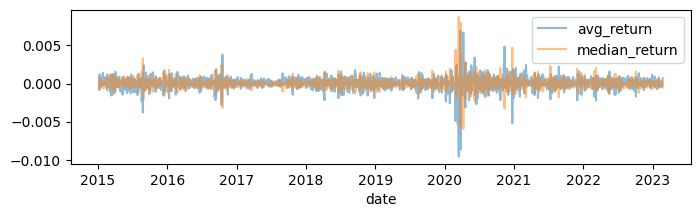

In [180]:
# visualize common return
common_return_df.plot(figsize = (8, 2), alpha = 0.5)

In [193]:
# calculate and visualize all returns 
all_return_df = pd.DataFrame(model.resid.values, index = return_dates, columns = ['specific_return'])
all_return_df['common_return'] = common_return_df.sum(axis = 'columns')
all_return_df['stock_return'] = single_return_df.values

<AxesSubplot: xlabel='date'>

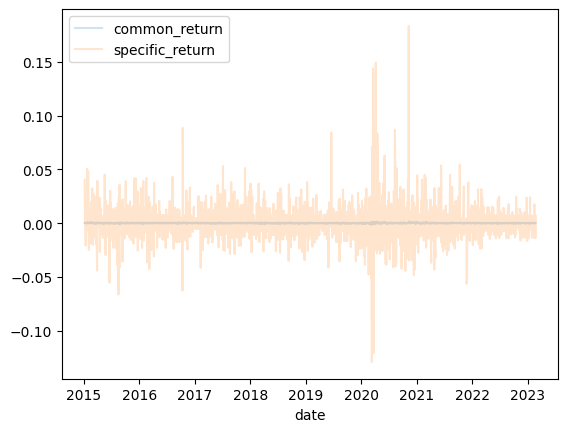

In [200]:
# all_return_df.head()
all_return_df[['common_return', 'specific_return']].plot(alpha = 0.2)